## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction


For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
### We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` read in the `ab_data.csv` data. Store it in `df` and take a look at the top few rows

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
### number of rows in the dataset
df.shape[0]

294478

In [4]:
### number of unique users in the dataset
df['user_id'].nunique()

290584

In [5]:
### Proportion of users converted
(df['converted']==1).mean()

0.11965919355605512

In [6]:
### number of times `new_page` and `treatment` don't line up

print((((df['group']!='treatment') & (df['landing_page']=='new_page'))|(((df['group']=='treatment')& (df['landing_page']!='new_page')))).sum())

3893


In [7]:
#Check for missing values

df[(((df['group']!='treatment') & (df['landing_page']=='new_page'))|(((df['group']=='treatment')& (df['landing_page']!='new_page'))))].isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. so we remove these rows and Store the new dataframe in **df2**.

In [8]:
df2 = df.drop(df[(((df['group']!='treatment') & (df['landing_page']=='new_page'))|(((df['group']=='treatment')& (df['landing_page']!='new_page'))))].index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
#number of unique users
df2['user_id'].nunique()

290584

In [11]:
# find duplicates
df2[df2['user_id'].duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

In [12]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
# drop the duplicated row
df2.drop(df2[df2['user_id'].duplicated()].index, inplace = True)

In [14]:
# check for duplicates
df2.user_id.duplicated().sum()

0

What is the probability of an individual converting regardless of the page they receive?

In [15]:
conv = (df2['converted']==1).mean()
conv

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
p_oldConv = (df2[df2['group']=='control']['converted']==1).mean()
p_oldConv

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
p_newConv = (df2[df2['group']=='treatment']['converted']==1).mean()
p_newConv

0.11880806551510564

What is the probability that an individual received the new page?

In [18]:
(df2['landing_page']=='new_page').mean()

0.5000619442226688

Acording to results from the previous cells we can conculde that:

the previous results are sufficient evidences to say that the new treatment page leads to more conversions:

* the probability an individual is in the treatment group and converted is 0.1188, while the probability an individual was in the control group and converted is 0.12, besides the probability that an individual recieved the new page or the old page are equal and = 0.5,  the two values are close to each other we can not come up with a decision from this.

* also due to timestamp we could get misleading values because a row would be marked as unique if at least the timestamp is unique, and the difference in the timestamp could be very small or the same user have different times of logging in, that would affect the results

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, we consider to make the decision just based on all the data provided. we assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%
then :

* Null hypothesis : **$p_{new}$** <= **$p_{old}$**
* Alternative hypothesis : **$p_{new}$** > **$p_{old}$**

Steps we will make:

1. Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

2. Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


the **convert rate** for $p_{new}$ under the null

In [19]:
p_new = (df2['converted']==1).mean()
print(p_new)

0.11959708724499628


the **convert rate** for $p_{old}$ under the null

In [20]:
p_old = (df2['converted']==1).mean()
print(p_old)

0.11959708724499628


In [21]:
# n_new, number of treatment groups

n_new = len(df2[df2['group']=='treatment'])
print(n_new)

145310


d. What is $n_{old}$?

In [22]:
# n_old, number of control groups

n_old = len(df2[df2['group']=='control'])
print(n_old)

145274


In [23]:
#e. Simulate n_new transactions with a convert rate of p_new under the null.

new_page_converted = np.random.binomial(2, p_new, n_new)

In [24]:
# f. Simulate n_old transactions with a convert rate of p_old under the null.

old_page_converted = np.random.binomial(2,p_old, n_old)

In [25]:
# find (P_new - P_old)

new_page_converted.mean() -old_page_converted.mean()

0.002432277770308522

Simulating 10,000 $p_{new}$ - $p_{old}$. Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
p_diffs = []
for _ in range(10000):
    new_page = np.random.binomial(n_new,p_new)/n_new
    old_page = np.random.binomial(n_old, p_old)/n_old
    p_diffs.append(new_page - old_page)
    
p_diffs= np.array(p_diffs)

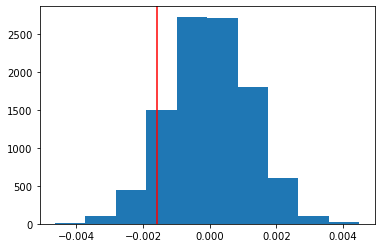

In [27]:
# histogram of p_diffs, it's expected to be normally distributed

plt.hist(p_diffs)
plt.axvline(p_newConv-p_oldConv, color = 'red')
plt.show()

**p-value**: p-value is the probability of observing our statistic when the null hypothesis is true


In [28]:
#calculating p-value
(p_diffs > (p_newConv-p_oldConv)).mean()

0.9093

since p-value is large (0.9) then we shouldn't move away from the null hypothesis.that is we failed to reject the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
#calculating p-value with built-in function

import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

df_old = df2[df2['landing_page']=='old_page']
df_new = df2[df2['landing_page']=='new_page']
convert_old = len(df_old[df_old['converted'] == 1])
convert_new = len(df_new[df_new['converted'] == 1])
n_old = len(df2[df2['landing_page']=='old_page'])
n_new = len(df2[df2['landing_page']=='new_page'])

stat, pval = proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative ='smaller')
stat, pval

(1.3109241984234394, 0.9050583127590245)

<a id='regression'></a>
### Part III - A regression approach

In this part, we will show that the result we acheived in the previous A/B test can also be acheived by performing regression.<br><br>

Since each row is either a conversion or no conversion, so we perform **logistic regression**

first we need to create a column for the intercept, and create a dummy variable column for which page each user received.
* we  add an **intercept** column
* we add **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
df2['intercept']=1
df2[['ab_page', 'delete']] = pd.get_dummies(df2['landing_page'])
df2[['group', 'tmp']] = pd.get_dummies(df2['landing_page'])
df2 = df2.drop(['tmp', 'delete', 'landing_page'], axis = 1)
df2.head()

,user_id,timestamp,group,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,0,0,1,0
1,804228,2017-01-12 08:01:45.159739,0,0,1,0
2,661590,2017-01-11 16:55:06.154213,1,0,1,1
3,853541,2017-01-08 18:28:03.143765,1,0,1,1
4,864975,2017-01-21 01:52:26.210827,0,1,1,0


In [31]:
# building & fitting the model

mod  = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [32]:
print(results.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Jan 2021   Pseudo R-squ.:               8.077e-06
Time:                        15:58:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007


from the model summary we can see that:

* the p-value associated with ab_page is 0.19
* we encoded the ab_page to have 1 when an individual receives the treatment, so we can use it in our model
* the p-value differes since here the null hypothesis is that the probability of conversion when an individual recieves the new page is less than the probability when an individual recieves the old page. **p_new < p_old**

while the null hypothesis in **PartII** was the conversion rate to the old_page is greater or equal to the conversion rate to new_page. ** p_old <= p_new**

we found in **PartII** that we fail to reject the null hypothesis, which means that in our sample the conversion rate to the old_page is greater **p_old > p_new**, so it makes sense to get the p-value here small so we can reject the null hypothesis here which is the opposite to the one in **PartII**

** Considering Other factors**

it is a good idea to consider other factors to add into our regression model

since we can not depend only on group, landing_page >> we may be misleaded with the results since it's possible that people reject the new_page because they get used to the old_page, or people accept the new_page because they got bored with the old_page this doesn't necessarily mean that the new_page added is good.

Now along with testing if the conversion rate changes for different pages, we also add an effect based on which country a user lives.

we read `countries.csv` and join it with our dataset

In [33]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,converted,intercept,ab_page
user_id,,,,,,
834778,UK,2017-01-14 23:08:43.304998,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,1,0,1,1
822059,UK,2017-01-16 14:04:14.719771,1,1,1,1
711597,UK,2017-01-22 03:14:24.763511,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,1,0,1,1


In [34]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])

In [35]:
# we drop one column because we need only two for three dummy variables

df_new = df_new.drop(['CA'], axis = 1)
df_new.head()

,country,timestamp,group,converted,intercept,ab_page,UK,US
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,1,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,1,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,1,0,1,1,1,0


from the summary below we can see that country alone doesn't affect the conversion rate, as the coefficients associated with the coutries are small and the p-values for them are small

In [36]:
mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']]) # I set the base for country to be 'CA'
results = mod.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 04 Jan 2021   Pseudo R-squ.:               2.323e-05
Time:                        15:58:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.

we have looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.
to do that we need to create new columns that represent the interaction between country and page, we ca multiply ab_page column with each dummy variable column for country  


In [37]:
### Create the new columns
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']

### build and fit our new model
mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US', 'UK_ab_page', 'US_ab_page']]) # I set the base for country to be 'CA'
results = mod.fit()

### print the result
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 04 Jan 2021   Pseudo R-squ.:               3.482e-05
Time:                        15:58:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.

from the coef values we can see that they are not equal, and we only need to add interactions between two variables if their slopes(the coef value here) are different and get equal after adding the interaction 

<a id='conclusions'></a>
## Conclusions

* from the results we get from z-test and calculating p-value with our hands which was equal to the one computed with z-test, we can see that the p-value is large.

* since we want to prove that the conversion rate of new_page is greater, we set the null to (p_new <= p_old) and the alternative which we want to prove (p_new > p_old)

* a large value for p-value, tells us that we shouldn't get away from the null hypothesis, we can say that we failed to reject the null hypothesis.

* as a result the conversion rate for the old_page is greater, so the company shouldn't implement this new_page.
